In [ ]:
# python 3.10.11

In [49]:
# imports
import calendar
import json
import math
import os
import sqlite3
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

import seaborn as sns; sns.set()
pd.set_option('display.max_columns', None) # show all columns of a dataframe
np.set_printoptions(threshold=np.inf) # remove limits on displaying numpy arrays
# pd.set_option('display.max_rows', None) # show all rows of a dataframe
# pd.set_option('display.max_colwidth', 10000) # show full width of dataframe columns

In [4]:
# variables
api_key = os.environ.get("API_KEY")
base_url = "https://api.themoviedb.org/3"

### Initial preparations

In [63]:
# Let's take a look at a default JSON response from "https://api.themoviedb.org/3/discover/movie"
params={
    "api_key": api_key,
    }
response = requests.get(f"{base_url}/discover/movie", params=params)
data = response.json()
if response.status_code == 200:
    display(data)
else:
    print("Error", response.status_code, "\n", response.text)


{'page': 1,
 'results': [{'adult': False,
   'backdrop_path': '/mExN6lJHmLeGjwDmDrNNjR4MdCq.jpg',
   'genre_ids': [28, 12, 16, 35, 10751],
   'id': 1011985,
   'original_language': 'en',
   'original_title': 'Kung Fu Panda 4',
   'overview': 'Po is gearing up to become the spiritual leader of his Valley of Peace, but also needs someone to take his place as Dragon Warrior. As such, he will train a new kung fu practitioner for the spot and will encounter a villain called the Chameleon who conjures villains from the past.',
   'popularity': 6623.028,
   'poster_path': '/wkfG7DaExmcVsGLR4kLouMwxeT5.jpg',
   'release_date': '2024-03-02',
   'title': 'Kung Fu Panda 4',
   'video': False,
   'vote_average': 6.874,
   'vote_count': 199},
  {'adult': False,
   'backdrop_path': '/deLWkOLZmBNkm8p16igfapQyqeq.jpg',
   'genre_ids': [9648, 14, 28, 12],
   'id': 763215,
   'original_language': 'en',
   'original_title': 'Damsel',
   'overview': "A young woman's marriage to a charming prince turns int

In [ ]:
# According to the documentation, each API call can display one page which corresponds to a max of 20 results. 
# We can find the maximum number of pages and movies when we make a single query, they correspond to the last and second-to-last values of the JSON response.

# Let's define a function to retrieve the total number of pages
def total_pages_movies():
    params={
        "api_key": api_key
        }
    response = requests.get(f"{base_url}/discover/movie", params=params)
    data = response.json()
    if response.status_code == 200:
        page_count = data['total_pages']
        movie_count = data['total_results']
        return page_count, movie_count
    else:
        print("Error", response.status_code, "\n", response.text)

page_count, movie_count = total_pages_movies()

print(f'There are {page_count} pages and {movie_count} movies in the discovery list.')

In [ ]:
# Now that we have the total amount of pages, let's try to retrieve the titles, genre, release date and rating for every movie in discovery.

all_movies =[]

for i in range(1, page_count + 1):
    params={
        "api_key": api_key,
        "page":i
        }
    response = requests.get(f"{base_url}/discover/movie", params=params)
    data = response.json()

    # Let's store the movie title and movie_ID into the movies array
    if response.status_code == 200:
        if ('results' in data) and (data['results']):   # if there is a 'results' array in the json file and if that array is not empty
            for movie in data['results']:
                title = movie.get('original_title', None)
                genres = movie.get('genre_ids', None)
                release_date = movie.get('release_date', None)
                rating = movie.get('vote_average', np.nan)
        all_movies.append([title, genres, release_date, rating])
    else:
        print(f'Error {response.status_code} at page {i}"\n"{response.text}')
        break

display(all_movies)

The TMDB API has a hard cap of 500 pages for any specific query.  
To circumvent the 500 page limit, let's try one year at a time. From current year back to 1870.  
<i>( first movies are from the late 1800s: https://en.wikipedia.org/wiki/List_of_cinematic_firsts)</i>

In [40]:
# Let's calculate the page_count for a query limited by year and see if it ever exceeds 500.

pages_count =[]
year = datetime.today().year
year_stop = 1870

def total_pages_movies_year(year):
    params={
        "api_key": api_key,
        "year": year
        }
    response = requests.get(f"{base_url}/discover/movie", params=params)
    data = response.json()
    if response.status_code == 200:
        page_count = data['total_pages']
        return page_count
    else:
        print("Error", response.status_code, "\n", response.text)


while year >= year_stop:
    pages_count.append({year : total_pages_movies_year(year)})
    year -= 1



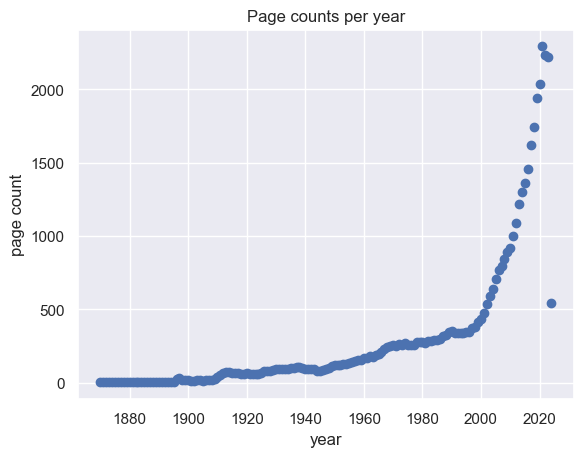

Max page count: 2292


In [41]:
# Visualize the distribution
x=[]
y=[]

for e in pages_count:
    x.extend(e.keys())
    y.extend(e.values())

_=plt.scatter(x,y)
_=plt.xlabel('year')
_=plt.title('Page counts per year')
_=plt.ylabel('page count')
plt.show()

# print the max page_count
print(f'Max page count: {max(y)}')


We can see from the graph that too many calls exceed 500 pages.  
Let's narrow the query even further by specifying the year and the month.

In [81]:
# To specify that type of range, we have to use the parameters primary_release_date.gte and primary_release_date.lte

pages_count = []
year = datetime.today().year
year_stop = 1870

def total_pages_movies_year(year, month):
    # We can find the number of days for any month and year by using the 'calendar' library
    last_day = calendar.monthrange(year, month)[1]
    params={
        "api_key": api_key,
        "year": year,
        "primary_release_date.gte": f"{year}-{month:02d}-01", 
        "primary_release_date.lte": f"{year}-{month:02d}-{last_day}" 
        }
    response = requests.get(f"{base_url}/discover/movie", params=params)
    data = response.json()
    if response.status_code == 200:
        page_count = data['total_pages']
        return page_count
    else:
        print("Error", response.status_code, "\n", response.text)


while year >= year_stop:
    for month in range(12,0,-1):
        pages_count.append([year, month, total_pages_movies_year(year, month)])
    year -= 1


Max page count: 221


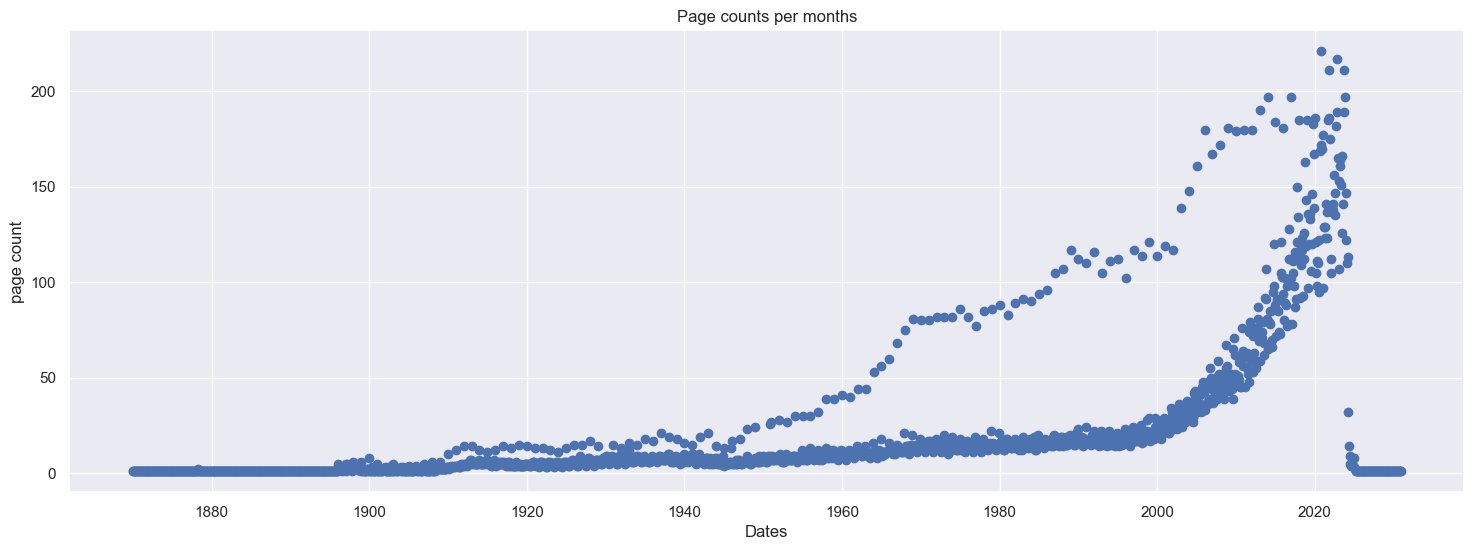

In [ ]:
# Visualize the distribution
x = []
y = []

for e in pages_count:
    x.append(datetime.strptime(str(e[0])+'-'+str(e[1]), '%Y-%m'))
    y.append(e[2])

_=plt.figure(figsize=(18, 6))
_=plt.scatter(x,y)
_=plt.title('Page counts per months')
_=plt.xlabel('Dates')
_=plt.ylabel('page count')

# print the max page_count
print(f'Max page count: {max(y)}')

plt.show()

All page counts stay under 500. We can use that query to retrieve all movies from the discovery list.